In [3]:
import pandas as pd


In [4]:
sle_pro_cox = pd.read_csv("/Volumes/data_files/UKB_data/immune_result/cox3/sle_pro_cox.csv")
sle_pro_5_cox = pd.read_csv("/Volumes/data_files/UKB_data/immune_result/cox3/sle_pro_5_cox.csv")
sle_pro_10_cox = pd.read_csv("/Volumes/data_files/UKB_data/immune_result/cox3/sle_pro_10_cox.csv")
sle_pro_15_cox = pd.read_csv("/Volumes/data_files/UKB_data/immune_result/cox3/sle_pro_15_cox.csv")

sle_pro_cox = sle_pro_cox[sle_pro_cox['Bonferroni']<0.05]
sle_pro_5_cox = sle_pro_5_cox[sle_pro_5_cox['Bonferroni']<0.05]
sle_pro_10_cox = sle_pro_10_cox[sle_pro_10_cox['Bonferroni']<0.05]
sle_pro_15_cox = sle_pro_15_cox[sle_pro_15_cox['Bonferroni']<0.05]

sle_pro_cox_cols = sle_pro_cox["Feature"].tolist()
sle_pro_cox_cols = sle_pro_cox_cols + ["SLE", "fp-SLE",'sex', 'ethnicity', 'alcohol_amount']
sle_pro_5_cox_cols = sle_pro_5_cox["Feature"].tolist()
sle_pro_5_cox_cols = sle_pro_5_cox_cols + ["SLE", "fp-SLE",'sex', 'ethnicity', 'alcohol_amount']
sle_pro_10_cox_cols = sle_pro_10_cox["Feature"].tolist()
sle_pro_10_cox_cols = sle_pro_10_cox_cols + ["SLE", "fp-SLE",'sex', 'ethnicity', 'alcohol_amount']
sle_pro_15_cox_cols = sle_pro_15_cox["Feature"].tolist()
sle_pro_15_cox_cols = sle_pro_15_cox_cols + ["SLE", "fp-SLE",'sex', 'ethnicity', 'alcohol_amount']


In [5]:
time_group = pd.read_csv("/Volumes/data_files/UKB_data/processed_data/sle_group.csv")

within_five = time_group[time_group["Group"]=="0-5"]
within_five_eid = within_five["eid"].tolist()

five_ten = time_group[time_group["Group"]=="5-10"]
five_ten_eid = five_ten["eid"].tolist()

ten_fifteen = time_group[time_group["Group"]=="10-15"]
ten_fifteen_eid = ten_fifteen["eid"].tolist()

In [ ]:
immune_basic = pd.read_csv("/Volumes/data_files/UKB_data/processed_data/immune_basic_fp.csv")
pro = pd.read_csv("/Volumes/data_files/UKB_data/processed_data/pro_sler")
st_features = pd.read_csv("/Volumes/data_files/UKB_data/processed_data/sle_student_t_features.csv")
immune_pro = pro.merge(immune_basic, on='eid', how='left')
immune_pro = immune_pro.merge(st_features[['eid', 'alcohol_amount']], on='eid', how='left')
unuse_col = ['RA', 'SS', 'Systemic Sclerosis', 'APS', 'Autoimmune thyroiditis', 'icd10_SLE_dates', 'icd10_RA_dates', 'icd10_SS_dates', 'icd10_Systemic Sclerosis_dates', 'icd10_APS_dates', 'icd10_Autoimmune thyroiditis_dates', 'srd_RA', 'srd_SS', 'srd_Systemic Sclerosis', 'srd_APS', 'srd_Autoimmune thyroiditis', 'bmi', 'date_attend', 'birth_year', 'birth_month', 'fp-len', 'fp-RA', 'fp-SS', 'fp-Systemic Sclerosis', 'fp-APS', 'fp-Autoimmune thyroiditis', 'age']
immune_pro.drop(columns=unuse_col, inplace=True)
print(immune_pro.columns.tolist())

In [ ]:
sle_pro = immune_pro[immune_pro["fp-SLE"] > 0]
sle_pro.drop(["srd_SLE"], axis=1, inplace=True)
sle_pro = sle_pro.fillna(sle_pro.median(numeric_only=True))

sle_pro_5 = sle_pro[sle_pro["eid"].isin(within_five_eid)]
sle_pro_10 = sle_pro[sle_pro["eid"].isin(five_ten_eid)]
sle_pro_15 = sle_pro[sle_pro["eid"].isin(ten_fifteen_eid)]
sle_control = sle_pro[sle_pro["SLE"]==0]
print(sle_pro_5.shape,sle_pro_10.shape,sle_pro_15.shape,sle_control.shape)

# sle_pro_5 = pd.concat([sle_pro_5, sle_control], ignore_index=True)
# sle_pro_10 = pd.concat([sle_pro_10, sle_control], ignore_index=True)
# sle_pro_15 = pd.concat([sle_pro_15, sle_control], ignore_index=True)

In [8]:
sle_pro = sle_pro[sle_pro_cox_cols]
sle_pro_5 = sle_pro_5[sle_pro_5_cox_cols]
sle_pro_10 = sle_pro_10[sle_pro_10_cox_cols]
sle_pro_15 = sle_pro_15[sle_pro_15_cox_cols]

In [11]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import NearestNeighbors
import statsmodels.api as sm
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import pdist
import numpy as np

def analyze_protein_trajectories(data, protein_cols, covariates, case_col='SLE', time_col='fp-SLE', n_matches=10, loess_frac=0.3, n_clusters=5):

    result = {}
    corrected_data = data.copy()
    for protein in protein_cols:
        # print("protein",protein)
        model = LinearRegression()
        X = data[covariates]
        y = data[protein]
        model.fit(X, y)
        corrected_data[protein] = y - model.predict(X)
    result['corrected_data'] = corrected_data

    cases = corrected_data[corrected_data[case_col] == 1]
    controls = corrected_data[corrected_data[case_col] == 0]
    nbrs = NearestNeighbors(n_neighbors=n_matches).fit(controls[covariates])
    distances, indices = nbrs.kneighbors(cases[covariates])
    matched_controls = {case_idx: controls.iloc[indices[i]].index.tolist() for i, case_idx in enumerate(cases.index)}

    z_scores = pd.DataFrame(index=matched_controls.keys(), columns=protein_cols)
    for case_idx, control_indices in matched_controls.items():
        for protein in protein_cols:
            control_values = corrected_data.loc[control_indices, protein]
            z = (corrected_data.loc[case_idx, protein] - control_values.mean()) / control_values.std()
            z_scores.loc[case_idx, protein] = z
    result['z_scores'] = z_scores

    loess_results = {}
    time_min = data[time_col].min()
    time_max = data[time_col].max()

    time_points = np.arange(time_min, time_max + 0.5, 0.5)
    
    for protein in protein_cols:
        x = data.loc[z_scores.index, time_col]
        y = z_scores[protein].dropna()
    
        if len(y) > 0:
            loess = sm.nonparametric.lowess
            fitted_values = loess(y, x, frac=loess_frac)

            loess_interpolated = np.interp(time_points, fitted_values[:, 0], fitted_values[:, 1])
            loess_results[protein] = np.column_stack((time_points, loess_interpolated))
    
    result['loess_results'] = loess_results
    

    loess_df = pd.DataFrame({
        protein: res[:, 1] if res is not None else [float('nan')] * len(data[time_col])
        for protein, res in loess_results.items()
    }).T

    loess_df = loess_df.dropna(axis=1).astype(float)

    dist_matrix = pdist(loess_df, metric='euclidean')  
    linkage_matrix = linkage(dist_matrix, method='ward')
    cluster_labels = fcluster(linkage_matrix, t=n_clusters, criterion='maxclust')
    result['clusters'] = {protein: cluster for protein, cluster in zip(loess_df.index, cluster_labels)}

    return result

In [12]:
protein_cols = [col for col in sle_pro.columns if col not in ['eid', 'SLE', 'fp-SLE', 'sex', 'ethnicity', 'alcohol_amount']]
covariates = ['sex', 'ethnicity']

result_5 = analyze_protein_trajectories(
    data=sle_pro,
    protein_cols=protein_cols,
    covariates=covariates,
    case_col='SLE',
    time_col='fp-SLE',
    n_matches=10,
    loess_frac=0.3,
    n_clusters=5
)


In [ ]:
import pandas as pd

loess_results = result_5['loess_results']
x_values = list(loess_results.values())[0][:, 0] 
df_loess = pd.DataFrame({"x": x_values})

for protein, values in loess_results.items():
    df_loess[protein] = values[:, 1]

df_loess.to_csv("/Volumes/data_files/UKB_data/immune_result/loess/sle_pro_loess_results.csv", index=False)

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import UnivariateSpline

moranthi_colors = [
    '#81acd8', '#f47958', '#53c4b5', '#a891cc', '#fca55b',
]

def plot_cluster_fitting_with_moranthi_separate(result, n_clusters, time_col='fp-SLE'):

    loess_results = result['loess_results']
    clusters = result['clusters']

    cluster_groups = {i: [] for i in range(1, n_clusters+1)}

    for protein, cluster in clusters.items():
        cluster_groups[cluster].append(protein)
        
    for cluster, proteins in cluster_groups.items():
        plt.figure(figsize=(8, 6))

        num_proteins = len(proteins)

        plt.title(f'Cluster {cluster} (Proteins: {num_proteins})', fontsize=16)

        all_z_scores = []
        for protein in proteins:
            if protein in loess_results:
                loess_data = loess_results[protein]
                z_scores = loess_data[:, 1] 
                all_z_scores.append(z_scores)

        if all_z_scores:
            avg_z_scores = np.mean(all_z_scores, axis=0)

            for protein in proteins:
                if protein in loess_results:
                    loess_data = loess_results[protein]
                    plt.plot(loess_data[:, 0], loess_data[:, 1], color=moranthi_colors[cluster-1], alpha=0.1) 

            loess_x = loess_data[:, 0]  
            spline = UnivariateSpline(loess_x, avg_z_scores, s=0.5) 
            plt.plot(loess_x, spline(loess_x), label=f'Spline Fit for Cluster {cluster}', color=moranthi_colors[cluster-1], linewidth=3)

        plt.gca().invert_xaxis()

        plt.xlabel("Years before diagnosis", fontsize=16)
        plt.ylabel('Expression', fontsize=16)
        plt.legend(loc='best', fontsize=10)

        plt.tight_layout()
        plt.savefig(f"Cluster_{cluster}_protein.pdf", format='pdf')
        plt.close()

plot_cluster_fitting_with_moranthi_separate(result_5, n_clusters=5)

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd  

def plot_loess_heatmap(loess_results, time_col, clusters=None):

    loess_df = pd.DataFrame({
        protein: pd.Series({t: v for t, v in res})
        for protein, res in loess_results.items()
        if res is not None
    }).fillna(0)

    if clusters:
        sorted_proteins = sorted(clusters.keys(), key=lambda x: clusters[x])
        loess_df = loess_df[sorted_proteins]

    plt.figure(figsize=(5, 6))  
    sns.heatmap(
        loess_df.T,
        cmap="RdBu_r",
        center=0,
        cbar_kws={'label': 'Z-score'},
        xticklabels=np.round(loess_df.index, 1),
        yticklabels=False,  
        vmin=-1.5,            
        vmax=1.5              
    )
    plt.xlabel('Years before diagnosis',fontsize=16)

    xticks_positions = np.arange(0, len(loess_df.index), 6)  # Positions for every 6th label
    xticks_labels = np.abs(loess_df.index[xticks_positions]).astype(int)  # Ensure positive integers without decimal points
    plt.xticks(xticks_positions, xticks_labels, rotation=0)

    plt.ylabel('Proteins',fontsize=16)
    plt.gca().invert_xaxis()

    plt.tight_layout()
    plt.savefig("Protein trajectories.pdf",format='pdf')
    plt.close()

In [24]:
plot_loess_heatmap(result_5['loess_results'], time_col='fp-SLE', clusters=result_5['clusters'])

In [25]:
def plot_selected_proteins_with_reversed_time(loess_results, selected_proteins, clusters=None, year_interval=6):

    filtered_results = {protein: loess_results[protein] for protein in selected_proteins if protein in loess_results}

    if not filtered_results:
        raise ValueError("No valid LOESS results for the selected proteins.")

    loess_df = pd.DataFrame({
        protein: pd.Series({-t: v for t, v in res})  
        for protein, res in filtered_results.items()
        if res is not None and len(res) > 0
    }).fillna(0)

    loess_df = loess_df.sort_index(ascending=True)

    if loess_df.empty:
        raise ValueError("LOESS results contain no valid data for plotting.")

    if clusters:
        sorted_proteins = sorted(selected_proteins, key=lambda x: clusters.get(x, float('inf')))
        loess_df = loess_df[sorted_proteins]

    plt.figure(figsize=(5, 6))  
    ax = sns.heatmap(
        loess_df.T,
        cmap="RdBu_r",
        center=0,
        cbar_kws={'label': 'Z-score'},
        xticklabels=False,  
        yticklabels=loess_df.columns,
        linecolor='black',   
        linewidths=0.5,       
        vmin=-1.5,            
        vmax=1.5              
    )

    xticks_positions = list(range(0, len(loess_df.index), year_interval))
    xticks_labels = [int(-loess_df.index[i]) for i in xticks_positions]
    plt.xticks(ticks=xticks_positions, labels=xticks_labels)  

    plt.xlabel('Years before diagnosis',fontsize=16)
    plt.yticks(rotation=0,fontsize=12)
    plt.tight_layout()
    plt.savefig("Selected Protein trajectories.pdf",format='pdf')

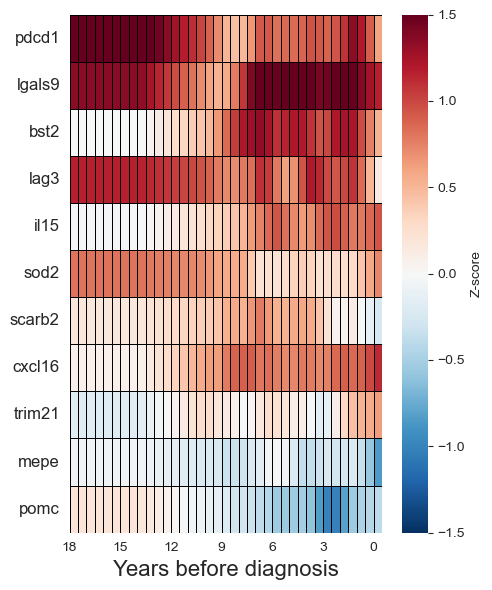

In [26]:
selected_proteins = ['pdcd1', 'lgals9', 'bst2', 'lag3', 'il15', 'sod2','scarb2', 'cxcl16', 'trim21', 'mepe', 'pomc']
plot_selected_proteins_with_reversed_time(
    loess_results=result_5['loess_results'],
    selected_proteins=selected_proteins
)

In [42]:
clusters = result_5['clusters']
df_clusters = pd.DataFrame(list(clusters.items()), columns=['Protein', 'Cluster'])
df_clusters.to_csv("Protein_cluster.csv",index=False)